In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT

# for creating custom gates
from qiskit import quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram


# for simulation
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city


# blochsphere for debugging hopefully
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

## The symmetric 4-city problem

solving the bottleneck travelling salesman problem using phase estimation.

### testing contraint:

 - 6 qubits for phase estimation.
 - 8 qubits initialized to the eigenvalue of the of the matrix $U$.
 - There are 3 hamilonian cycles, so we need eigenvalue and estimation qubits for each.
 - To solve the constraint problem we need a new operator $U$ satifying a max edge weight.

<div>
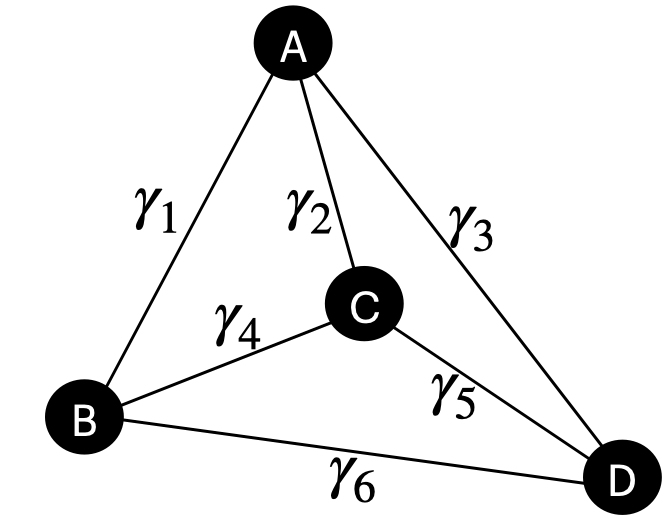
</div>

### we can assign arbitrary weights

$$\Large 1: A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_4}C \xrightarrow{\gamma_5}D\xrightarrow{\gamma_3}A: 4 + 4 + \mathbf{5} + 4 = 17$$

$$\Large 2: A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_6}D \xrightarrow{\gamma_5}C\xrightarrow{\gamma_2}A: 4 + \mathbf{6} + 5 + 2 = 17$$

$$\Large 3: A\xrightarrow{\gamma_2}C \xrightarrow{\gamma_4}B \xrightarrow{\gamma_6}D\xrightarrow{\gamma_3}A: 2 + 4 + \mathbf{6} + 4 = 16$$

In [2]:
eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

n = 3 #estimation qubits
eig = eigstatelist[2] # 0,1 solutions -> 2, 
eig = eig[::-1] # needs to be reversed
sim_types = ['statevector_simulator', 'aer_simulator']
sim_type = sim_types[1] 


In [3]:

gamma_1 = 4 # a <-> b
gamma_2 = 2 # a <-> c
gamma_3 = 4 # a <-> d
gamma_4 = 4 # b <-> c
gamma_5 = 5 # c <-> d
gamma_6 = 6 # b <-> d

weights = []

for i in range(1, 7):
    variable_name = "gamma_" + str(i)
    # Assuming you have variables like number_1, number_2, etc.
    current_number = locals()[variable_name]
    weights.append(current_number)

weights = np.array(weights)
print(weights)

[4 2 4 4 5 6]


**we need to normalize by largest hamiltonian cycle**

we can just use the values we have above for now, but might be worth considering what strategy works best.
 - simplest solution would be to normalize based on the sum of all edge weights
 
 $$\Large w = \frac{w}{\mathrm{sum}(w)}$$

In [4]:
eps = 1
#weights = weights / (max(weights) + eps) * 2 * np.pi

weights = weights / np.sum(weights)
#weights = weights / np.sum(weights) * np.pi

print('normalized weights: {}'.format(weights))

## solutions
print('solution 1: {}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[5] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[5] + weights[2]))

print('solutions after max weight removed')
print('solution 1: {}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0]  + weights[4] + weights[1]))
print('solution 3: {:.3f}'.format(weights[1] + weights[3] + weights[2]))

normalized weights: [0.16 0.08 0.16 0.16 0.2  0.24]
solution 1: 0.68
solution 2: 0.68
solution 3: 0.64
solutions after max weight removed
solution 1: 0.68
solution 2: 0.44
solution 3: 0.400


To construct $U$, we need to compute the tensor product of diagonal matrices $U_j$, where $ 1 \leq j \leq N$. $N$ denotes the number of cities in total.

$$\Large\left[U_j \right]_{kk} = \frac{1}{\sqrt{N}}e^{i\gamma_{jk}}$$


$$\Large U = \bigotimes_j^N U_j$$


for our contstraint test, we simply need a tensor product of 4 matrices:

$$\Large U = U_1 \otimes U_2 \otimes U_3 \otimes U_4$$

lets have a closer look at the matrix $U_1$
$$ \Large
\begin{bmatrix}
  1 & 0 & 0 & 0 \\
  0 & e^{i\gamma_{12}} & 0 & 0 \\
  0 & 0 & e^{i\gamma_{13}} & 0 \\
  0 & 0 & 0 & e^{i\gamma_{14}} \\
\end{bmatrix}
$$

constructing the large matrix U is straight forward. I am a little confused on how to construct a controlled-U operation such that we have the appropriate phase kickback. The 2018 paper does a decomposition, and claims that a $CU$ matrix can simply be achieved by the tensor product of the smaller $CU_J$ matrices. Need to confirm how this works.

A control gate can simply be constructed:

$$ \Large
\begin{bmatrix}
  \mathbb{1} & 0 \\
  0 & U \\
\end{bmatrix}
$$ 


#### clarification:

to construct a control gate, we need an equal amount of diagonal elements for the identity matrix above as we have in the diagonal of U, implying we double the size of U and store 1s in the first half of the diagonal. Ordering becomes an issue due to qiskit circuit convention, luckily they have a built in operator we can use.

## creating CU matrix

In [5]:
### need the four values for each sub distance matrix:

m = 8                                              # eigenvalue qubits
U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[4] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(U) != 0))                    # confirming only the diagonal is being used.

Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate = Ugate.control()


True


## Confirming where the solutions are:



In [6]:
# solution 1: 2.1362830044410597
# solution 2: 2.1362830044410592
# solution 3: 2.0106192982974678
# U_angles = U_angles[U_angles > 2] ## range here is -pi to pi. Changing it to 0 to 2pi
# U_angles = U_angles[U_angles < 2.2]
# U_angles
#print(np.where(U_angles==2.0106)) ### solution 3
#print(np.where(U_angles == 2.1363)) ## solution 1 & 2


### according to May 2018 paper
U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
U_angles[eiglistint] + 1



array([0.68, 0.68, 0.68, 0.64, 0.64, 0.6 ])

## Creating CU Prime matrix (removing max edge weight)

In [7]:
### need the four values for each sub distance matrix:

max_index = np.where(weights == np.max(weights))[0][0] ## largest weight in weights index
weights[max_index] = 0                                 ## setting the largest weight to zero

U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[4] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(Up) != 0))# confirming only the diagonal is being used.

UPgate = qi.Operator(Up).to_instruction()
UPgate.label = "CU'"
CUPgate = UPgate.control()


True


In [8]:
U_angles = np.diag(np.angle(Up))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
U_angles[eiglistint] 


array([-0.32, -0.32,  0.44, -0.36,  0.4 , -0.4 ])

In [9]:

qr = QuantumRegister(n, name = 'phase')
qr2 = QuantumRegister(m, name = 'eigenstate')
cr = ClassicalRegister(n, 'output')

qrp = QuantumRegister(n, name = 'phase two')
qr2p = QuantumRegister(m, name = 'eigstate two')
crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(qr,qr2,cr,qrp,qr2p,crp)


# Apply H-Gates to counting qubits:
for qubit in range(2*n):
    if qubit < n:
        qc.h(qubit)
    else:
        qc.h(qubit + m)
        

for ind, val in enumerate(eig):
    if(int(val)):
        qc.x(ind + n)
        qc.x(ind + 2*n + m)


qc.draw()

┌───┐
       phase_0: ┤ H ├
                ├───┤
       phase_1: ┤ H ├
                ├───┤
       phase_2: ┤ H ├
                ├───┤
  eigenstate_0: ┤ X ├
                └───┘
  eigenstate_1: ─────
                ┌───┐
  eigenstate_2: ┤ X ├
                ├───┤
  eigenstate_3: ┤ X ├
                └───┘
  eigenstate_4: ─────
                     
  eigenstate_5: ─────
                     
  eigenstate_6: ─────
                ┌───┐
  eigenstate_7: ┤ X ├
                ├───┤
   phase two_0: ┤ H ├
                ├───┤
   phase two_1: ┤ H ├
                ├───┤
   phase two_2: ┤ H ├
                ├───┤
eigstate two_0: ┤ X ├
                └───┘
eigstate two_1: ─────
                ┌───┐
eigstate two_2: ┤ X ├
                ├───┤
eigstate two_3: ┤ X ├
                └───┘
eigstate two_4: ─────
                     
eigstate two_5: ─────
                     
eigstate two_6: ─────
                ┌───┐
eigstate two_7: ┤ X ├
                └───┘
      output: 3/═════
                     
  output two: 3/═════

In [10]:
eig_qubits = np.arange(0,m) + n
eig_qubits2 = np.arange(0,m) + 2*n + m

repetitions = 1
for counting_qubit in range(n):
    applied_qubits = np.append([counting_qubit], [eig_qubits])
    applied_qubits2 = np.append([counting_qubit + m + n], [eig_qubits2])
    for i in range(repetitions):
        qc.append(CUgate, list(applied_qubits)); # This is CU
        qc.append(CUPgate, list(applied_qubits2));
    repetitions *= 2
    
qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), qr)
qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), qrp)

qc.measure(qr,cr)
qc.measure(qrp,crp)

qc.draw()

┌───┐                                                        »
       phase_0: ┤ H ├───■────────────────────────────────────────────────────»
                ├───┤   │                                                    »
       phase_1: ┤ H ├───┼───────■───────■────────────────────────────────────»
                ├───┤   │       │       │                                    »
       phase_2: ┤ H ├───┼───────┼───────┼───────■───────■───────■───────■────»
                ├───┤┌──┴──┐ ┌──┴──┐ ┌──┴──┐ ┌──┴──┐ ┌──┴──┐ ┌──┴──┐ ┌──┴──┐ »
  eigenstate_0: ┤ X ├┤0    ├─┤0    ├─┤0    ├─┤0    ├─┤0    ├─┤0    ├─┤0    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_1: ─────┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─»
                ┌───┐│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_2: ┤ X ├┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_3: ┤ X ├┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─»
                └───┘│  CU │ │  CU │ │  CU │ │  CU │ │  CU │ │  CU │ │  CU │ »
  eigenstate_4: ─────┤4    ├─┤4    ├─┤4    ├─┤4    ├─┤4    ├─┤4    ├─┤4    ├─»
                     │     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_5: ─────┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─»
                     │     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_6: ─────┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─»
                ┌───┐│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_7: ┤ X ├┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─»
                ├───┤└─────┘ └─────┘ └─────┘ └─────┘ └─────┘ └─────┘ └─────┘ »
   phase two_0: ┤ H ├───■────────────────────────────────────────────────────»
                ├───┤   │                                                    »
   phase two_1: ┤ H ├───┼───────■───────■────────────────────────────────────»
                ├───┤   │       │       │                                    »
   phase two_2: ┤ H ├───┼───────┼───────┼───────■───────■───────■───────■────»
                ├───┤┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐»
eigstate two_0: ┤ X ├┤0     ├┤0     ├┤0     ├┤0     ├┤0     ├┤0     ├┤0     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_1: ─────┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├»
                ┌───┐│      ││      ││      ││      ││      ││      ││      │»
eigstate two_2: ┤ X ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_3: ┤ X ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├»
                └───┘│  CU' ││  CU' ││  CU' ││  CU' ││  CU' ││  CU' ││  CU' │»
eigstate two_4: ─────┤4     ├┤4     ├┤4     ├┤4     ├┤4     ├┤4     ├┤4     ├»
                     │      ││      ││      ││      ││      ││      ││      │»
eigstate two_5: ─────┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├»
                     │      ││      ││      ││      ││      ││      ││      │»
eigstate two_6: ─────┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├»
                ┌───┐│      ││      ││      ││      ││      ││      ││      │»
eigstate two_7: ┤ X ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├»
                └───┘└──────┘└──────┘└──────┘└──────┘└──────┘└──────┘└──────┘»
      output: 3/═════════════════════════════════════════════════════════════»
                                                                             »
  output two: 3/═════════════════════════════════════════════════════════════»
                                                                             »
«                ┌───────┐┌─┐               
«       phase_0: ┤0      ├┤M├───────────────
«                │       │└╥┘┌─┐            
«       ph

In [11]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [12]:
simulator = Aer.get_backend(sim_type)

In [13]:
qc = transpile(qc, simulator)  #### Doesnt like the inverse Quantum Fourier transform without decomposition
#qc.draw()

In [14]:
# Run and get counts
result = simulator.run(qc).result()
counts = result.get_counts(qc)
#plot_histogram(counts, title='check')

In [15]:
counts

{'110 100': 1,
 '000 100': 1,
 '010 010': 1,
 '111 010': 1,
 '111 100': 2,
 '001 000': 1,
 '101 000': 1,
 '100 000': 7,
 '111 110': 3,
 '011 100': 23,
 '101 111': 3,
 '011 011': 11,
 '001 001': 1,
 '101 011': 2,
 '100 111': 16,
 '101 100': 3,
 '110 110': 4,
 '110 101': 7,
 '001 111': 3,
 '011 000': 9,
 '011 111': 11,
 '101 101': 32,
 '110 011': 1,
 '111 111': 1,
 '011 001': 7,
 '110 111': 1,
 '010 011': 1,
 '001 110': 5,
 '010 110': 16,
 '010 111': 4,
 '001 101': 21,
 '100 011': 7,
 '110 001': 1,
 '000 000': 1,
 '011 101': 195,
 '000 101': 8,
 '010 101': 26,
 '111 101': 8,
 '000 001': 1,
 '100 101': 240,
 '100 010': 4,
 '011 010': 7,
 '100 100': 25,
 '011 110': 119,
 '100 001': 5,
 '100 110': 146,
 '010 000': 3,
 '000 110': 7,
 '101 110': 16,
 '000 111': 1,
 '010 100': 4}

In [16]:
max(counts, key=counts.get)

'100 101'

In [17]:
def bitstring_converter(string):
    
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
            
        if i == len(string)-1:
            values.append(value)
    
    return values

In [18]:
bitstring_converter(max(counts, key=counts.get))

[0.5, 0.625]

In [19]:
np.arange(0,1, 1/(2**(n)))

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875])

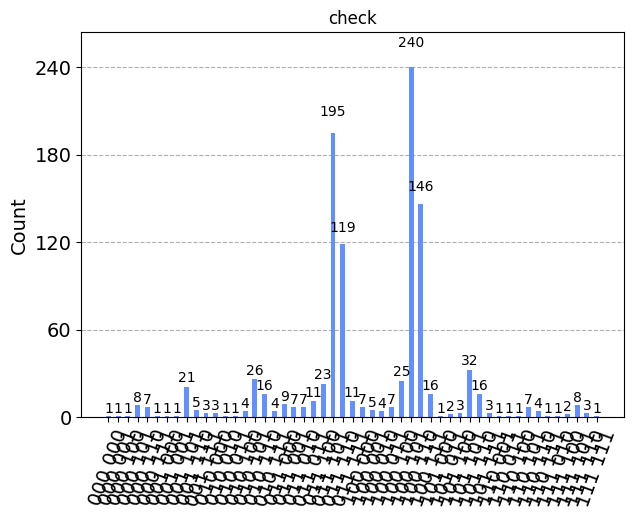

In [20]:
plot_histogram(counts, title='check')